In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys

from settings import *
sys.path.insert(0, PYSBF_PATH)
from pysbf import *

From configuration file, get mag zero point (em1), extinction, eperadu, arcsec per pixel (pscale), psf, and exposure time (dt)

In [84]:
# em0 extinction-corrected mag of an object giving one electron per total exposure time. 
# Atmospheric extinction is 0 for HST/JWST, but we should still include it.

# atm: airmass
# secz
# em1: mag zero point

# m=-2.5logf+m_1-A*secz+C*color

mag_zero_point = em1
# M1_J    =               26.822  /  m1: m for 1 e/sec at top of atm, color=0
M1_J calcualtor ...

 # ?  atm = 0 for HST, JWST (space telescopes)
em0 =  -2.5*alog10(eperadu / dt) + em1 #- atm*secz

#E/ADU_J =                 1.00  /  Electrons per ADU in averaged image
#ETIME_J =               2011.7  /  Exposure time (sec)

# aext =   absfilt(color, abext)

# em0 = em0 - aext

em0_corrected = em0 - 2.5log10(dt) - ext_band (MW extinction from NED at the desired waveband)

em0_after_all_corrections = M1STAR_J = 35.081  /  m1star: m for 1e- net (no MW ext, C=gxy)


SyntaxError: invalid syntax (4004139638.py, line 12)

In [85]:
skymag = em0 - 2.5*alog10(sky/pscale**2) + aext

NameError: name 'em0' is not defined

```
bar.r = <r>  : average r in the anulus
    
<r> <g> : in *c# files
k is the index 


PSF:  (order,K0,K1) = (4,  0, 15)   Scale = 1.846E+08   Sum/Scale = 1.000
MASK: (X0,Y0) = ( 567, 562)   (R0,R1) = (  32,  64)   (A0,A1) = (  0,360)
AVG:  <1> = 0.030    <g> = 56418.5    <r> =  49.7    E(k=0) =  1551.3
RESIDUAL VARIANCE: m_res =   0.00
P0=  2.206E+01 +/-  3.52E-01   P1=  1.553E+00   Kfit=(25, 60)   Cor cf= 0.958

   k   Expect(k)   Data(k) Efit/E0 Data/E0   P0*E      P1      P0*E+P1   P0       P1       RMS    Corcof
   0.0 1.500E+03 5.168E+05  1.0000 3.33E+02 2.21E+01 1.55E+00 2.36E+01 2.87E+01 7.61E-01 5.90E+03 22.059
   1.0 1.498E+03 4.156E+05  0.9901 2.68E+02 2.18E+01 1.55E+00 2.34E+01 2.86E+01 7.73E-01 5.55E+03*******
   2.0 1.495E+03 2.462E+05  0.9803 1.59E+02 2.16E+01 1.55E+00 2.32E+01 2.82E+01 8.17E-01 4.44E+03  0.809
   3.0 1.490E+03 1.080E+05  0.9706 6.96E+01 2.14E+01 1.55E+00 2.30E+01 2.80E+01 8.51E-01 3.98E+03  0.822
   
   ```

power_c0.txt
power_c1.txt
power_c2.txt   
<r> average radius
<g> average galaxy
R0, R1 : inner, outer anulus in pixel
A0, A1: angles definine the region
    
P0 +
P1 + 
Kfit: Range of fitting wavelengths
Cor cf: correlation coefficient

In [86]:
class Params:
    
    def print(self):
        for attribute, value in self.__dict__.items():
            if isinstance(value, (int, float, np.float64)):
                print(f"{attribute}: {value}")

In [87]:
import re 


class ParameterExtractor(Params):
    def __init__(self, text):
        self.text = text
        self.extract_parameters()

    def extract_parameters(self):
        self.extract_psf_parameters()
        self.extract_mask_parameters()
        self.extract_avg_parameters()
        self.extract_residual_variance()
        self.extract_p0_p1_kfit()

    def extract_psf_parameters(self):
        pattern = r"PSF:\s+\(order,K0,K1\)\s+=\s+\((\d+),\s*(\d+),\s*(\d+)\)"
        match = re.search(pattern, self.text)
        if match:
            self.PSF_order = int(match.group(1))
            self.PSF_K0 = int(match.group(2))
            self.PSF_K1 = int(match.group(3))
        else:
            self.PSF_order = None
            self.PSF_K0 = None
            self.PSF_K1 = None

    def extract_mask_parameters(self):
        pattern_mask = r"MASK:\s+\(X0,Y0\)\s+=\s+\(\s*(\d+),\s*(\d+)\)\s+\(R0,R1\)\s+=\s+\(\s*(\d+),\s*(\d+)\)\s+\(A0,A1\)\s+=\s+\(\s*(\d+),\s*(\d+)\)"
        match_mask = re.search(pattern_mask, self.text)
        if match_mask:
            self.mask_x0 = int(match_mask.group(1))
            self.mask_y0 = int(match_mask.group(2))
            self.R0 = int(match_mask.group(3))
            self.R1 = int(match_mask.group(4))
            self.A0 = int(match_mask.group(5))
            self.A1 = int(match_mask.group(6))
        else:
            self.mask_x0 = None
            self.mask_y0 = None
            self.R0 = None
            self.R1 = None
            self.A0 = None
            self.A1 = None

    def extract_avg_parameters(self):
        pattern_avg = r"AVG:\s+<1>\s*=\s*([\d.E+-]+)\s+<g>\s*=\s*([\d.E+-]+)\s+<r>\s*=\s*([\d.E+-]+)\s+E\(k=0\)\s*=\s*([\d.E+-]+)"
        match_avg = re.search(pattern_avg, self.text)
        if match_avg:
            self.Ave_1 = float(match_avg.group(1))
            self.Avg_g = float(match_avg.group(2))
            self.Avg_r = float(match_avg.group(3))
            self.E_k = float(match_avg.group(4))
        else:
            self.Ave_1 = None
            self.Avg_g = None
            self.Avg_r = None
            self.E_k = None

    def extract_residual_variance(self):
        pattern_residual_variance = r"RESIDUAL VARIANCE:\s+m_res\s*=\s*([\d.E+-]+)"
        match_residual_variance = re.search(pattern_residual_variance, self.text)
        if match_residual_variance:
            self.m_res = float(match_residual_variance.group(1))
        else:
            self.m_res = None

    def extract_p0_p1_kfit(self):
        pattern_p0_p1_kfit = r"P0=\s*([\d.E+-]+)\s*\+/-\s*([\d.E+-]+)\s*P1=\s*([\d.E+-]+)\s*Kfit=\((\d+),\s*(\d+)\)\s*Cor cf=\s*([\d.E+-]+)"
        match_p0_p1_kfit = re.search(pattern_p0_p1_kfit, self.text)
        if match_p0_p1_kfit:
            self.P0 = float(match_p0_p1_kfit.group(1))
            self.dP0 = float(match_p0_p1_kfit.group(2))
            self.P1 = float(match_p0_p1_kfit.group(3))
            self.Kfit = (int(match_p0_p1_kfit.group(4)), int(match_p0_p1_kfit.group(5)))
            self.Corr_cf = float(match_p0_p1_kfit.group(6))
        else:
            self.P0 = None
            self.dP0 = None
            self.P1 = None
            self.Kfit = None
            self.Corr_cf = None


In [88]:
!ls *c*.txt

power_c0.txt  power_c1.txt  power_c2.txt


In [89]:
_ = Logtext("power_c0.txt", "C0")
_ = Logtext("power_c1.txt", "C1")
_ = Logtext("power_c2.txt", "C2")

In [90]:
def extract_power(powerFile):
    
    with open(powerFile) as f:
        text = f.read()

    # Create an instance of ParameterExtractor
    return ParameterExtractor(text)
    

power_C0 = extract_power("power_c0.txt")
power_C0.print()

PSF_order: 4
PSF_K0: 0
PSF_K1: 15
mask_x0: 567
mask_y0: 562
R0: 32
R1: 64
A0: 0
A1: 360
Ave_1: 0.03
Avg_g: 56418.5
Avg_r: 49.7
E_k: 1551.3
m_res: 0.0
P0: 22.06
dP0: 0.352
P1: 1.553
Corr_cf: 0.958


In [91]:
lkn_File = '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/codes/notebooks/output/Outputs_u12517/u12517_eb317d7f178c'
lkn_File += '/u12517_se_lknjj.lkn6'

lkn_File 

'/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/codes/notebooks/output/Outputs_u12517/u12517_eb317d7f178c/u12517_se_lknjj.lkn6'

In [92]:
_ = Logtext(lkn_File, "lkn6")

In [93]:
with open(lkn_File, 'r') as f:
    
    lkn_lines = f.readlines()

In [94]:
n_header = 0 
for l in lkn_lines[:5]:
    if "lines of header information" in l:
        n_header = int(l.split("lines")[0].strip())
    
n_header

31

In [95]:
param_list = ["Cmax", "Cnorm", "Alpha", "Delta", "Gamma", "Gnorm", "SN", "sec/pixel"]
  
    
P = Params()


if n_header > 0:
    for param in param_list:
        
        for line in lkn_lines[:n_header]:
            
            if param in line and "=" in line:
                s = np.float64([s for s in line.split("=")[1].split(" ") if s!=""][0])
                setattr(P, param.replace("/", "_"), s)
                    
P.print() 

Cmax: 25.64407
Cnorm: 0.23487
Alpha: 1.2075
Delta: 1.4
Gamma: 0.25
Gnorm: 2.67241
SN: 10.55181
sec_pixel: 0.128


In [96]:
P.sec_pixel

0.128

### From n1234j.lkn6,

Get number of predicted fit lines npred from line 3.

- Get pscale (plate scale) from lkn6 or from config file + 
- Load an array with `r = ran`, `m_faintcutoff = emf`, residual variance `m_all = emres` (see below)
- Get the GCLF peak mag `Cmax` from header section +
- Get the GCLF parameters `cnorm`, `alpha`, `delta` + 
- Get the galaxy parameters `gamma`, `gnorm` +
- Get `S/N` used for selecting objects (sigdet) +

### Set up parameters:
- Set `emgalsec=34.5 for AB mags`, 30.5 for Vega (just use **AB for now**)
- Set dm = 0.04 mag as an input parameter
- Set `prfix = input` parameter, 0 by default, to increase Pr when `emdiff > 0`. 

- Load an array with `r = ran`, `m_faintcutoff = emf`, residual variance `m_all = emres`

r=ran   
faint_m=m_faint   --> emf  (faint cutoff)
m_all=emres   ---> emres (residual variance)

```Compute the average faint mag cutoff: because the annulus mean radius <r> = barr is not on the same grid as the lkn output, we have to interpolate.
    ```

find: at <r>
    - m_all --> emres --> emr 
    - m.1 --> emf   --> emcut
    
emdiff = cmax - emcut

In [97]:
# Residual variance PER PIXEL in magnitudes, V = 1*f^2

In [98]:
for i, line in enumerate(lkn_lines):
    if "Residual variance" in line:
        break

df = pd.read_csv(lkn_File, delim_whitespace=True, skiprows=i+2)

df = df.rename(columns = {"m":"bright_m", "m.1":"faint_m"})

df.head()

/tmp/ipykernel_1019089/190715336.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(lkn_File, delim_whitespace=True, skiprows=i+2)


,r,bright_m,faint_m,m_gc,m_gxy,m_all,slope,bias
0,14.0,20.0,23.37,26.64,28.68,26.63,0.0,0.0
1,22.0,20.0,23.87,27.25,29.02,27.23,0.0,0.0
2,30.0,20.0,24.19,27.69,29.24,27.66,0.0,0.0
3,38.0,20.0,24.43,28.03,29.40,27.99,0.0,0.0
4,46.0,20.0,24.61,28.31,29.53,28.25,0.0,0.0


In [99]:
power_c_ = power_C0

residual_m = emres = df["m_all"].values               # get emr = residual variance
faint_m = emf = df["faint_m"].values                  # get emcut = faint cutoff
R = ran = df["r"].values

emr = np.interp(power_c_.Avg_r, R, residual_m)
emcut = np.interp(power_c_.Avg_r, R, faint_m)

# positive means that GCLF is fainter than the cutoff, so smaller and negative values are good
emdiff = P.Cmax - emcut
emdiff

0.964694999999999

In [110]:
emcut

24.679375

In [111]:
P.Cnorm : #up and down normalization, how much to multiply the GCFF by in order to normalized the 

0.23487

In [112]:

# Cnorm : scale factor for the GCLF

In [101]:
P.print()

Cmax: 25.64407
Cnorm: 0.23487
Alpha: 1.2075
Delta: 1.4
Gamma: 0.25
Gnorm: 2.67241
SN: 10.55181
sec_pixel: 0.128


In [102]:
# Set emgalsec=34.5 for AB mags, 30.5 for Vega (just use AB for now)

emgalsec = 34.5

# Set dm = 0.04 mag as an input parameter

dm = 0.04 

# Set prfix = input parameter, 0 by default, to increase Pr when emdiff is positive. 

prfix = 0 

In [103]:
# Galaxy density at mcut (#/mag/arcmin^2)

gdens = P.Gnorm * 10**(P.Gamma*(emcut - emgalsec)) * (60*60)

gplus = P.Gnorm * 10**(P.Gamma*(emcut + dm - emgalsec)) * (60*60)

In [104]:
# Get GC density at mcut (#/mag/arcmin^2)

pscale = P.sec_pixel
delta = P.Delta
alpha = P.Alpha
barr = power_c_.Avg_r

cdens = P.Cnorm / (pscale/60.)**2 * barr**(-alpha) * np.exp(-0.5*((emcut - P.Cmax)/delta)**2)

cplus = P.Cnorm / (pscale/60.)**2 * barr**(-alpha) * np.exp(-0.5*((emcut + dm - P.Cmax)/delta)**2)

In [105]:
barg = power_c_.Avg_g

In [106]:
elfn = np.log10(gdens + cdens)

elfs = ( np.log10(gplus + cplus) - np.log10(gdens + cdens) ) / dm

In [108]:
pscale, psf

NameError: name 'psf' is not defined

In [109]:
barg =  power_c_.Avg_g   # average galaxy brightness

In [ ]:
p1: noise  - P1 on the top of the SBF output

In [ ]:
sigdet = 4.5   # signal to noise used in likenew

In [ ]:

emexp = em0 – 2.5*np.alog10(2*sigdet*np.sqrt(2*np.max(1.0, p1) * barg * (psf/pscale)^2))

In [ ]:
# Basic starting point for defining pr(k):

pr = 10**(-0.8*(emr-em0)) / barg

In [ ]:
# If prfix>0, include an additional contribution to Pr:

# this is the implementation of yessoft
# if prfix>0:
#     pr = pr * ( 1 + (10.**(0.4*emdiff) * prfix )

In [ ]:
alp = 1 + 2.5*elfs

pr = pr * (1. + 5/3. * (3.-alp)**2 / (49.-(3.-alp)**2)

dpr = pr * amax1( 0.25, 2*(emcut-emexp) )

 

In [ ]:
"""
"""

In [54]:
power_C0 = extract_power("power_c0.txt")
power_C1 = extract_power("power_c1.txt")
power_C2 = extract_power("power_c2.txt")

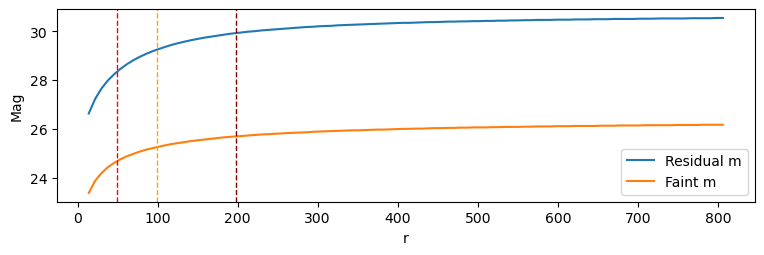

In [56]:
fig, ax = plt.subplots(figsize=(9, 2.5))

ax.plot(R, residual_m, label = 'Residual m')
ax.plot(R, faint_m, label = 'Faint m')

ax.axvline(x=power_C0.Avg_r, color='red', linestyle='--', linewidth=1)
ax.axvline(x=power_C1.Avg_r, color='orange', linestyle='--', linewidth=1)
ax.axvline(x=power_C2.Avg_r, color='maroon', linestyle='--', linewidth=1)

ax.set_xlabel("r")
ax.set_ylabel("Mag")
ax.legend()

In [57]:
# Interpolating to find the corresponding y value
y = np.interp(power_C0.Avg_r, R, residual_m)

In [58]:
y

28.35175

### An example of bestfluc

@ `codes/notebooks/data/wfc3/u12517/u12517doj.MBAR`

```
u12517doj:
 A_B = 0.59   e/ADU =  1.00   Exp = 2012   m_1  = 26.822   sky = 21.84   GCLF peak = 25.87
Aext =0.144   A_atm = 0.000  secz = 0.00   m_1* = 34.937   grot% = 0.00   Prfix% =  0.0  yessoft
Area  <1>   <r">  <mu> DPcut phcut magdiff  m0  +/-    P1   m_r  +/-   m_g   m_f  +/-  mbar  +/-
J.c0 0.033   6.4 18.66 25.35 25.48  0.52 25.11 0.01  2.16 26.55 0.14  0.00 25.15 0.01 31.64 0.02
J.c1 0.131  12.7 19.92 25.75 26.12  0.12 25.72 0.00  2.11 27.18 0.14  0.00 25.76 0.01 31.59 0.02
J.c2 0.501  25.4 21.31 26.03 26.68 -0.16 26.35 0.00  2.74 27.62 0.14  0.00 26.41 0.02 31.51 0.03
J.ne 0.453  49.4 22.83 26.20 26.97 -0.33 27.00 0.00  6.54 27.88 0.14  0.00 27.13 0.03 31.42 0.06
J.se 0.447  51.0 22.92 26.21 26.94 -0.34 27.06 0.01  7.38 27.88 0.14  0.00 27.19 0.04 31.46 0.07
J.sw 0.499  50.7 22.87 26.20 26.99 -0.34 27.05 0.01  6.43 27.88 0.14  0.00 27.18 0.04 31.50 0.07
J.nw 0.445  49.6 22.91 26.20 26.95 -0.33 27.05 0.00  7.24 27.88 0.14  0.00 27.18 0.04 31.46 0.07

      frac    P0    <P0>   +/-   P1     Pr   G/sky  P1/P0  Pr/P0 P-/P0  Pfluc  +/-   Pf/P1
J.c0  0.90  22.43  22.54  0.28  2.16   1.57 16.401  0.096  0.070   1.1  20.86  0.49   9.65
J.c1  0.89  23.39  23.35  0.19  2.11   1.58  5.103  0.090  0.068   1.0  21.81  0.44  10.33
J.c2  0.85  25.97  25.80  0.19  2.74   2.52  1.425  0.105  0.097   1.1  23.45  0.66   8.56

c0 Accepted: Pfluc =  20.86 +/-   0.49
c1 Accepted: Pfluc =  21.81 +/-   0.44
c2 Accepted: Pfluc =  23.45 +/-   0.66

Best guess: Pf =  21.79 +/-  1.13, Chi/N = 4.97.    mbar = 31.59 +/- 0.05

Chi^2/N unacceptable, delete c2 and try again

c0 Accepted: Pfluc =  20.86 +/-   0.49
c1 Accepted: Pfluc =  21.81 +/-   0.44

Best guess: Pf =  21.39 +/-  1.12, Chi/N = 2.10.    mbar = 31.61 +/- 0.05

```